In [205]:
import os
import pandas as pd
from tqdm import tqdm
import requests
from PIL import Image
from io import BytesIO
import json
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Literal, List, Union
from random import sample
from functools import partial

In [128]:
MAIN_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(MAIN_DIR, "data")
PARENT_DL_DIR = "https://data.lhncbc.nlm.nih.gov/public/Pills"
METADATA_DIR = os.path.join(DATA_DIR, "metadata")
REFERENCE_DIR = os.path.join(DATA_DIR, "reference")
CONSUMER_DIR = os.path.join(DATA_DIR, "consumers")

In [204]:
def convert_ndc_format(ndc_id: str):
    ndc_id_filled = ndc_id.zfill(11)
    return ndc_id_filled[:5] + "-" + ndc_id_filled[5:9] + "-" + ndc_id_filled[9:]

def plot_images(image_list: Union[str, List[str]]):
    if isinstance(image_list, str):
        img_data = Image.open(image_list)
        img_data = np.array(img_data)
        plt.figure()
        plt.imgshow(img_data)
    else:
        plt.figure(figsize = (20, 20 * len(image_list)))
        for idx, img_path in enumerate(image_list):
            img_data = Image.open(img_path)
            img_data = np.array(img_data)
            plt.subplot(1, len(image_list), idx + 1)
            plt.imshow(img_data)

def custom_sample(population: pd.Series, k: int=5):
    return sample(list(population.values), k)

def extract_metadata(
    metadata_content: Dict,
    format: Literal["original", "reference"] = "original"
    ):
    
    if format == "original":
        extracted_metadata = {
            "ndc11": convert_ndc_format(metadata_content["NDC11"]),
            "part": metadata_content["Part"],
            "name": metadata_content["ProprietaryName"],
            "file_name": metadata_content["File"]["Name"],
            "file_type": metadata_content.get("Layout") or metadata_content.get("Class"),
            "metadata": {
                'shape': metadata_content["Shape"],
                'color': metadata_content["Color"],
                'imprint': metadata_content["Imprint"],
                'imprintColor': metadata_content.get("ImprintColor", ""),
                'imprintType': metadata_content["ImprintType"],
                }
        }
        
    elif format == "reference":
        extracted_metadata = {
            "labelled": {
                "ndc11": metadata_content["ndc11"],
                "part": metadata_content["part"],
                "name": metadata_content["name"],
                "file_name": metadata_content["rxnavImageFileName"],
                "file_type": "MC_API_RXNAV_V1.3",
                "metadata": {
                    'shape': metadata_content["mpc"]["shape"],
                    'color': metadata_content["mpc"]["color"],
                    'imprint': metadata_content["mpc"].get("imprint", None),
                    'imprintColor': metadata_content["mpc"].get("imprintColor", ""),
                    'imprintType': metadata_content["mpc"].get("imprintType", "N/A"),
                    }
                },
            "unlabelled": {
                "ndc11": metadata_content["ndc11"],
                "part": metadata_content["part"],
                "name": metadata_content["name"],
                "file_name": metadata_content["nlmImageFileName"],
                "file_type": "MC_API_NLMIMAGE_V1.3",
                "metadata": {
                    'shape': metadata_content["mpc"]["shape"],
                    'color': metadata_content["mpc"]["color"],
                    'imprint': metadata_content["mpc"].get("imprint", None),
                    'imprintColor': metadata_content["mpc"].get("imprintColor", ""),
                    'imprintType': metadata_content["mpc"].get("imprintType", "N/A"),
                    }
                }
            }
    else:
        raise ValueError("Not supported format")

    return extracted_metadata

In [154]:
master_df = pd.read_csv(os.path.join(DATA_DIR, "metadata", "directory_consumer_grade_images.csv"))
master_df.columns = master_df.columns.str.lower()
# master_df["NDC11"] = master_df["NDC11"].apply(lambda x: convert_ndc_format(x))
# master_df.to_csv(os.path.join(DATA_DIR, "metadata", "directory_consumer_grade_images.csv"), index=False)
master_df.head()

,ndc11,part,image,layout,name
0,00002-3227-30,1,PillProjectDisc69/images/CLLLLUPGIX7J8MP1WWQ9W...,C3PI_Reference,STRATTERA 10MG
1,00002-3227-30,1,PillProjectDisc98/images/PRNJ-AXZIQ!HUQKJJBP_D...,C3PI_Reference,STRATTERA 10MG
2,00002-3227-30,1,PillProjectDisc10/images/79U-YY6M1UUR6F127ZMAC...,C3PI_Test,STRATTERA 10MG
3,00002-3227-30,1,PillProjectDisc11/images/7WVFV5H74!ELFNQ_GUH92...,C3PI_Test,STRATTERA 10MG
4,00002-3227-30,1,PillProjectDisc20/images/B4CH0R9B7PEQ6GORRX-8X...,C3PI_Test,STRATTERA 10MG


In [155]:
print("Total number of rows:", len(master_df))
print("Total number of unique drugs:", len(master_df["ndc11"].unique()))
print("Total number of unique drugs and parts:", len(master_df[["ndc11", "part"]].drop_duplicates()))

Total number of rows: 133770
Total number of unique drugs: 4864
Total number of unique drugs and parts: 5014


# Download Test dataset

## Download

In [167]:
DATASET_SIZE = 2000
NO_CONSUMER_IMAGES = 5

In [228]:
reference_df = master_df[master_df["layout"] == "MC_CHALLENGE_V1.0"]
reference_count_df = reference_df.groupby(["ndc11", "part"])["ndc11"].value_counts().reset_index()
reference_count_df = reference_count_df[(reference_count_df["count"]==2)&(reference_count_df["part"]==1)]
reference_list = reference_count_df["ndc11"].values[:DATASET_SIZE]
reference_df = reference_df[reference_df["part"] == 1]
reference_df = reference_df[reference_df["ndc11"].isin(reference_list)]
reference_df["reference_count"] = reference_df.groupby("ndc11")["image"].rank()
print("Number of rows in reference dataset:", len(reference_df))
print("Number of pills in reference dataset:", len(reference_df["ndc11"].unique()))

consumer_df = master_df[master_df["layout"] == "C3PI_Test"]
consumer_df = consumer_df[consumer_df["part"] == 1]
consumer_df = consumer_df[consumer_df["ndc11"].isin(reference_list)]

print("Number of rows in consumer dataset:", len(consumer_df))
print("Number of pills in consumer dataset:", len(consumer_df["ndc11"].unique()))

sampled_consumer_df = consumer_df.groupby("ndc11").agg({"image": partial(custom_sample, k=NO_CONSUMER_IMAGES)}).reset_index()
final_test_df = pd.concat(
    [
        sampled_consumer_df[["ndc11"]],
        pd.DataFrame(sampled_consumer_df["image"].values.tolist(), columns=[f"consumer_{i+1}" for i in range(5)])
    ], axis=1
)
first_reference = reference_df[reference_df["reference_count"] == 1][["ndc11", "image"]].rename(columns={"image": "first_reference"})
second_reference = reference_df[reference_df["reference_count"] == 2][["ndc11", "image"]].rename(columns={"image": "second_reference"})

final_test_df = final_test_df.merge(first_reference, how="inner", on="ndc11")
final_test_df = final_test_df.merge(second_reference, how="inner", on="ndc11")

print(len(final_test_df))

Number of rows in reference dataset: 4000
Number of pills in reference dataset: 2000
Number of rows in consumer dataset: 36141
Number of pills in consumer dataset: 2000


2000


In [ ]:
# Download all reference and consumer images
# with open(os.path.join(DATA_DIR, "consumers", "MC_CHALLENGE_V1_test.txt"), 'a') as f:

#     for filename in tqdm(test_df["image"].values, total=len(test_df["image"].values)):
#         img_url = os.path.join(PARENT_DL_DIR, filename)
#         download_url = os.path.join(DATA_DIR, "consumers", filename)
#         if not os.path.exists(os.path.dirname(download_url)):
#             os.makedirs(os.path.dirname(download_url), exist_ok=True)
            
#         img_data = requests.get(img_url).content
        
#         if img_url.endswith("JPG") or img_url.endswith("PNG"):
#             # Image
#             img = Image.open(BytesIO(img_data))           
#             img.save(download_url)
        
#         elif img_url.endswith("WMV"):
#             with open(download_url, 'wb') as handler:
#                 handler.write(img_data)
        
#         f.write(download_url + "\n")

# Reference Dataset

In [6]:
reference_df = pd.read_csv(os.path.join(DATA_DIR, "metadata", "directory_reference_images_updated.csv"))
reference_df.columns = reference_df.columns.str.lower()
print("Number of rows in reference df:", len(reference_df))
print("Number of unique pills in reference df:", len(reference_df["ndc11"].unique()))
reference_df.head()

Number of rows in reference df: 4392
Number of unique pills in reference df: 4236


,ndc11,part,rxcui,name,rxnavimageobjectid,rxnavimagefilename,nlmimagefilename,rxnav 120,rxbase 120,rxnav 300,rxbase 300,rxnav 600,rxbase 600,rxnav 800,rxbase 800,rxnav 1024,rxbase 1024,rxnav original,rxbase original
0,00093-0311-01,1,978006,Loperamide Hydrochloride 2 MG Oral Capsule,185643662,00093-0311-01_RXNAVIMAGE10_26211358.jpg,00093-0311-01_NLMIMAGE10_6315B1FD.jpg,image/images/gallery/120/00093-0311-01_RXNAVIM...,image/images/gallery/120/00093-0311-01_NLMIMAG...,image/images/gallery/300/00093-0311-01_RXNAVIM...,image/images/gallery/300/00093-0311-01_NLMIMAG...,image/images/gallery/600/00093-0311-01_RXNAVIM...,image/images/gallery/600/00093-0311-01_NLMIMAG...,image/images/gallery/800/00093-0311-01_RXNAVIM...,image/images/gallery/800/00093-0311-01_NLMIMAG...,image/images/gallery/1024/00093-0311-01_RXNAVI...,image/images/gallery/1024/00093-0311-01_NLMIMA...,image/images/gallery/original/00093-0311-01_RX...,image/images/gallery/original/00093-0311-01_NL...
1,00093-3165-01,1,197985,Minocycline 50 MG Oral Capsule,185646490,00093-3165-01_RXNAVIMAGE10_36231B28.jpg,00093-3165-01_NLMIMAGE10_19270CA8.jpg,image/images/gallery/120/00093-3165-01_RXNAVIM...,image/images/gallery/120/00093-3165-01_NLMIMAG...,image/images/gallery/300/00093-3165-01_RXNAVIM...,image/images/gallery/300/00093-3165-01_NLMIMAG...,image/images/gallery/600/00093-3165-01_RXNAVIM...,image/images/gallery/600/00093-3165-01_NLMIMAG...,image/images/gallery/800/00093-3165-01_RXNAVIM...,image/images/gallery/800/00093-3165-01_NLMIMAG...,image/images/gallery/1024/00093-3165-01_RXNAVI...,image/images/gallery/1024/00093-3165-01_NLMIMA...,image/images/gallery/original/00093-3165-01_RX...,image/images/gallery/original/00093-3165-01_NL...
2,00093-0810-01,1,198045,Nortriptyline 10 MG Oral Capsule,185646437,00093-0810-01_RXNAVIMAGE10_24231228.jpg,00093-0810-01_NLMIMAGE10_34271A58.jpg,image/images/gallery/120/00093-0810-01_RXNAVIM...,image/images/gallery/120/00093-0810-01_NLMIMAG...,image/images/gallery/300/00093-0810-01_RXNAVIM...,image/images/gallery/300/00093-0810-01_NLMIMAG...,image/images/gallery/600/00093-0810-01_RXNAVIM...,image/images/gallery/600/00093-0810-01_NLMIMAG...,image/images/gallery/800/00093-0810-01_RXNAVIM...,image/images/gallery/800/00093-0810-01_NLMIMAG...,image/images/gallery/1024/00093-0810-01_RXNAVI...,image/images/gallery/1024/00093-0810-01_NLMIMA...,image/images/gallery/original/00093-0810-01_RX...,image/images/gallery/original/00093-0810-01_NL...
3,00093-0811-01,1,317136,Nortriptyline 25 MG Oral Capsule,185646420,00093-0811-01_RXNAVIMAGE10_20231018.jpg,00093-0811-01_NLMIMAGE10_15270A98.jpg,image/images/gallery/120/00093-0811-01_RXNAVIM...,image/images/gallery/120/00093-0811-01_NLMIMAG...,image/images/gallery/300/00093-0811-01_RXNAVIM...,image/images/gallery/300/00093-0811-01_NLMIMAG...,image/images/gallery/600/00093-0811-01_RXNAVIM...,image/images/gallery/600/00093-0811-01_NLMIMAG...,image/images/gallery/800/00093-0811-01_RXNAVIM...,image/images/gallery/800/00093-0811-01_NLMIMAG...,image/images/gallery/1024/00093-0811-01_RXNAVI...,image/images/gallery/1024/00093-0811-01_NLMIMA...,image/images/gallery/original/00093-0811-01_RX...,image/images/gallery/original/00093-0811-01_NL...
4,00093-0812-01,1,198046,Nortriptyline 50 MG Oral Capsule,185646464,00093-0812-01_RXNAVIMAGE10_2D2316D8.jpg,00093-0812-01_NLMIMAGE10_DD0E6EE3.jpg,image/images/gallery/120/00093-0812-01_RXNAVIM...,image/images/gallery/120/00093-0812-01_NLMIMAG...,image/images/gallery/300/00093-0812-01_RXNAVIM...,image/images/gallery/300/00093-0812-01_NLMIMAG...,image/images/gallery/600/00093-0812-01_RXNAVIM...,image/images/gallery/600/00093-0812-01_NLMIMAG...,image/images/gallery/800/00093-0812-01_RXNAVIM...,image/images/gallery/800/00093-0812-01_NLMIMAG...,image/images/gallery/1024/00093-0812-01_RXNAVI...,image/images/gallery/1024/00093-0812-01_NLMIMA...,image/images/gallery/original/00093-0812-01_RX...,image/images/gallery/original/00093-0812-01_NL...


In [ ]:
# # Fill in reference_df
# reference_df = pd.read_csv(os.path.join(DATA_DIR, "metadata", "directory_reference_images.csv"))
# test_id2name = master_df[['ndc11', 'name']].drop_duplicates().set_index("ndc11").to_dict()["name"]
# reference_no_name_df = reference_df[reference_df["name"].isna()]

# for idx, no_name_pill_id in enumerate(reference_no_name_df["ndc11"]):
#     if no_name_pill_id in list(test_id2name.keys()):
#         reference_df.loc[reference_df["ndc11"] == no_name_pill_id, "name"] = test_id2name[no_name_pill_id]
#     else:
#         print(idx, no_name_pill_id)
        
# reference_df.to_csv(os.path.join(DATA_DIR, "metadata/directory_reference_images_updated.csv"))

# with open(os.path.join(DATA_DIR, "rximage", "MONGOexport", "rximagesAll.json"), "r") as f:
#     reference_metadata = json.load(f)
    
# for metadata in reference_metadata:
#     part = metadata['part']
#     rxnavImageFileName = metadata['rxnavimagefilename']
#     reference_df.loc[reference_df["rxnavimagefilename"] == rxnavImageFileName, "part"] = part
    
# reference_df.to_csv(os.path.join(DATA_DIR, "metadata/directory_reference_images_updated.csv"), index=False)

In [7]:
reference_list = list(reference_df["ndc11"].unique())

# Prepare Metadata File

## Download all metadata Files

In [64]:
# # Download all metadata
# import xmltodict

# for idx in range(1, 111):

#     metadata_url = f"https://data.lhncbc.nlm.nih.gov/public/Pills/ALLXML/PillProjectDisc{idx}.xml"
#     metadata = requests.get(metadata_url).content
#     metadata_dict = xmltodict.parse(metadata)
#     image_list = metadata_dict['MedicosConsultants']['ImageExport']['Image']
#     image_dict = {
#         metadata["File"]["Name"]: metadata for metadata in image_list
#     }
    
#     with open(os.path.join(DATA_DIR, "metadata", f"PillProjectDisc{idx}.json"), "w") as f:
#         json.dump(image_dict, f)

# # Combine metadata into 1 single json file
# master_metadata = {}

# for metadata_file in os.listdir(os.path.join(METADATA_DIR, "all_metadata")):
#     metadata_folder = metadata_file[:-5]
#     with open(os.path.join(METADATA_DIR, "all_metadata", metadata_file), "r") as f:
#         metadata_dict = json.load(f)
#     for file_name, metadata_content in metadata_dict.items():
#         image_url = os.path.join(metadata_folder, "images", file_name)
#         extracted_metadata = extract_metadata(metadata_content, format="original")
#         master_metadata[image_url] = extracted_metadata
        
# with open(os.path.join(METADATA_DIR, "master_metadata.json"), "w") as f:
#     json.dump(master_metadata, f)

## Check metadata and validate consistency

In [41]:
with open(os.path.join(METADATA_DIR, "master_metadata.json"), "r") as f:
    master_metadata = json.load(f)

In [241]:
pill_names = []
pill_metadatas = []

for _, row_content in final_test_df.iterrows():
    metadata1 = master_metadata[row_content["first_reference"]]
    metadata2 = master_metadata[row_content["second_reference"]]
    assert row_content["ndc11"] == metadata1["ndc11"] == metadata2["ndc11"], "NDCID mismatches for {}".format(row_content["ndc11"])
    assert metadata1["part"] == metadata2["part"], "Part mismatches for {}".format(row_content["ndc11"])
    assert metadata1["name"] == metadata2["name"], "Name mismatches for {}".format(row_content["ndc11"])
    assert metadata1["metadata"] == metadata2["metadata"], "Metadata mismatches for {}".format(row_content["ndc11"])
    pill_names.append(metadata1["name"])
    pill_metadatas.append(metadata1["metadata"])
    
final_test_df["name"] = pill_names
final_test_df["metadata"] = pill_metadatas

In [242]:
final_test_df.to_csv(os.path.join(DATA_DIR, "exp_metadata.csv"), index=False)

In [247]:
final_test_df.columns

Index(['ndc11', 'consumer_1', 'consumer_2', 'consumer_3', 'consumer_4',
       'consumer_5', 'first_reference', 'second_reference'],
      dtype='object')

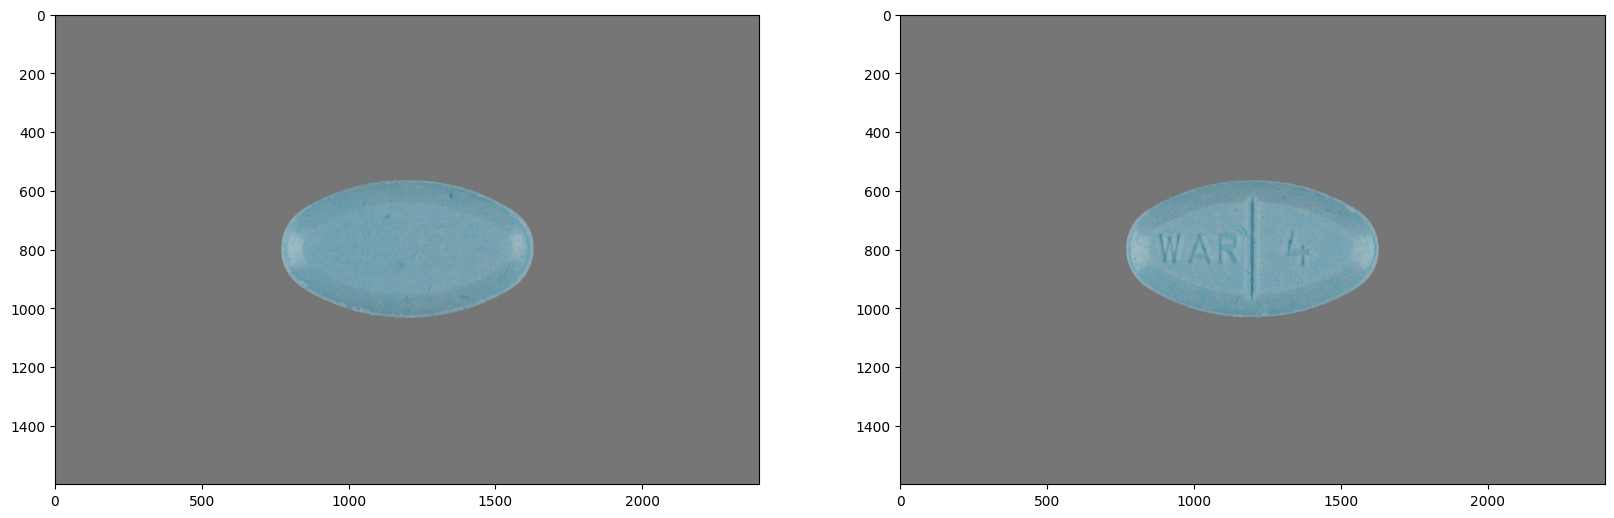

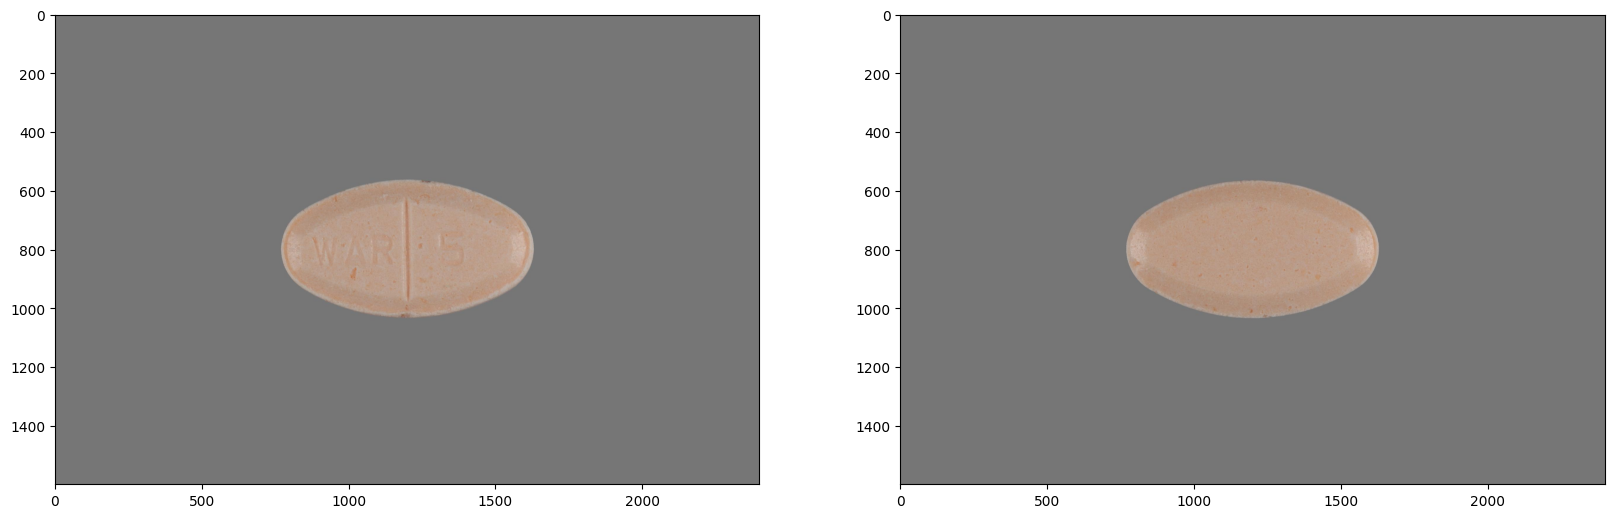

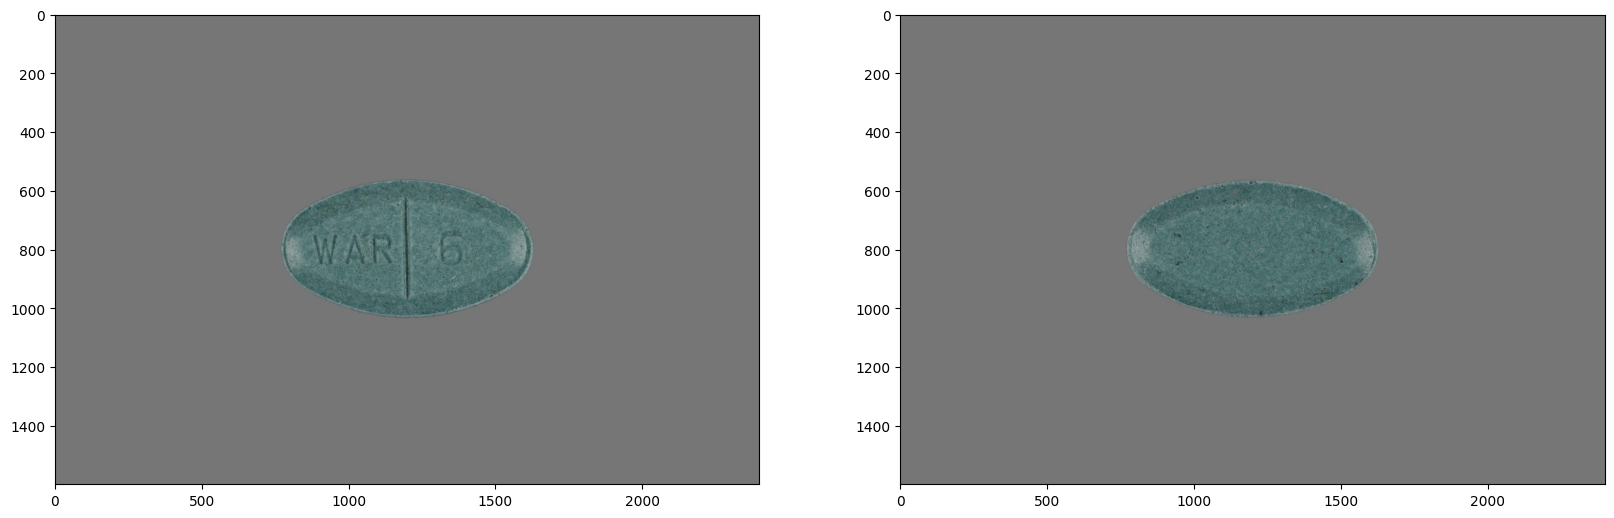

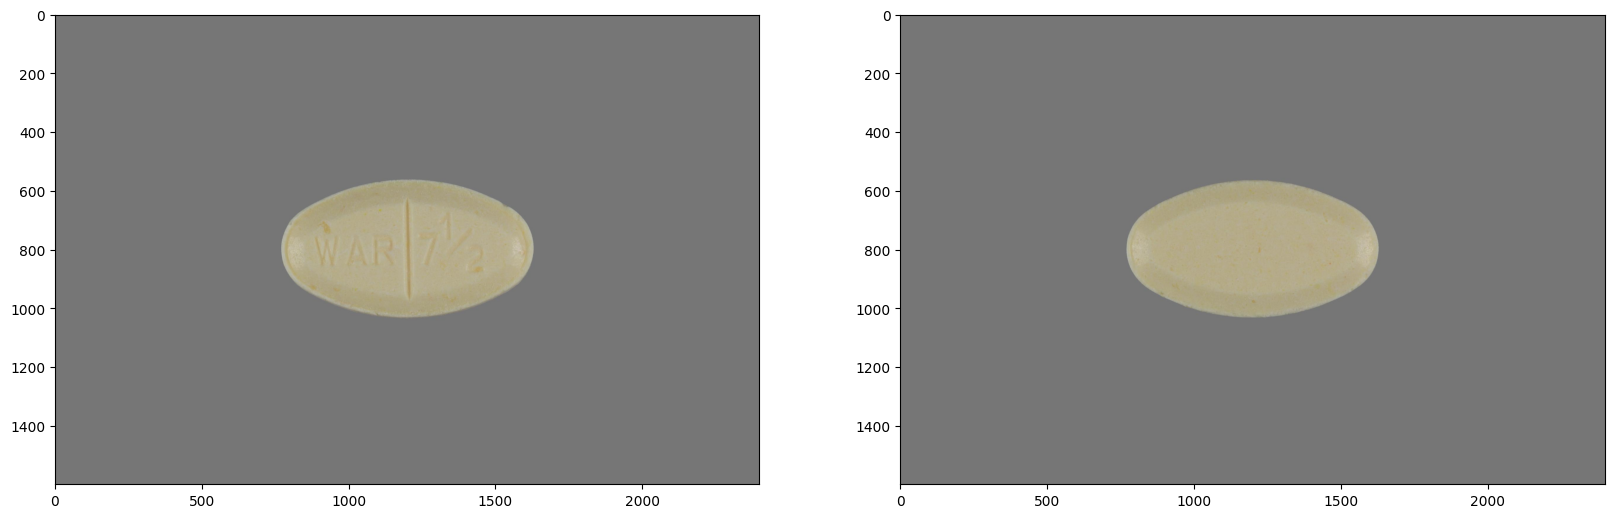

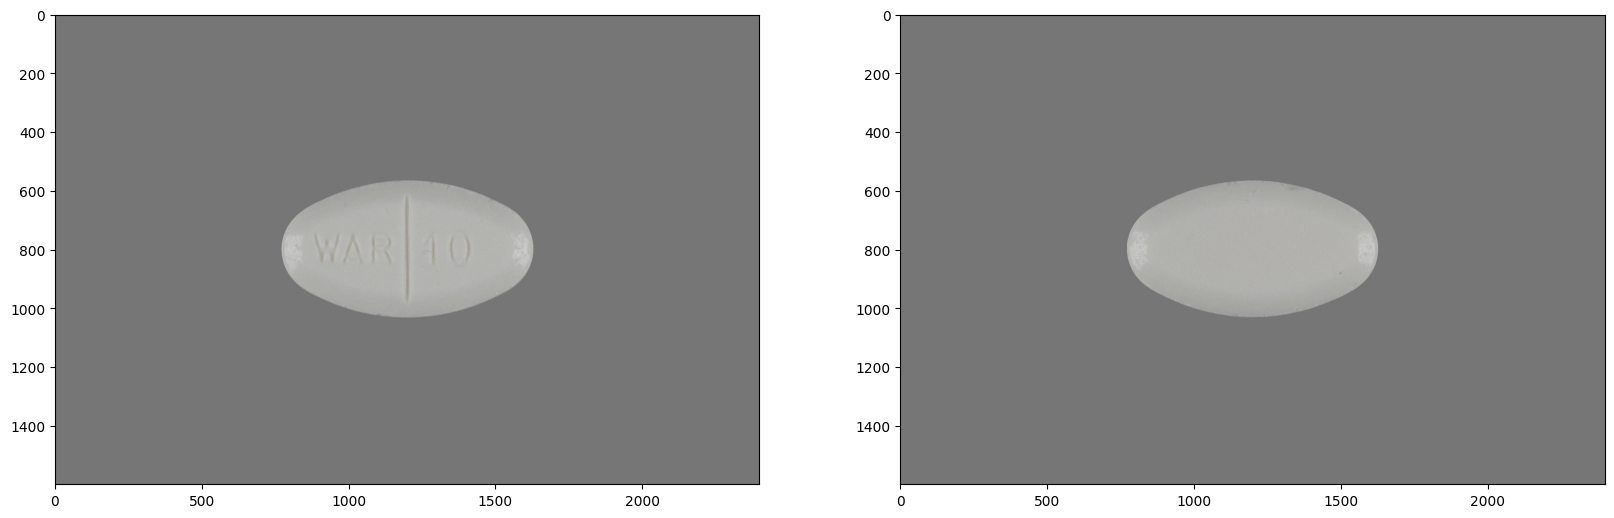

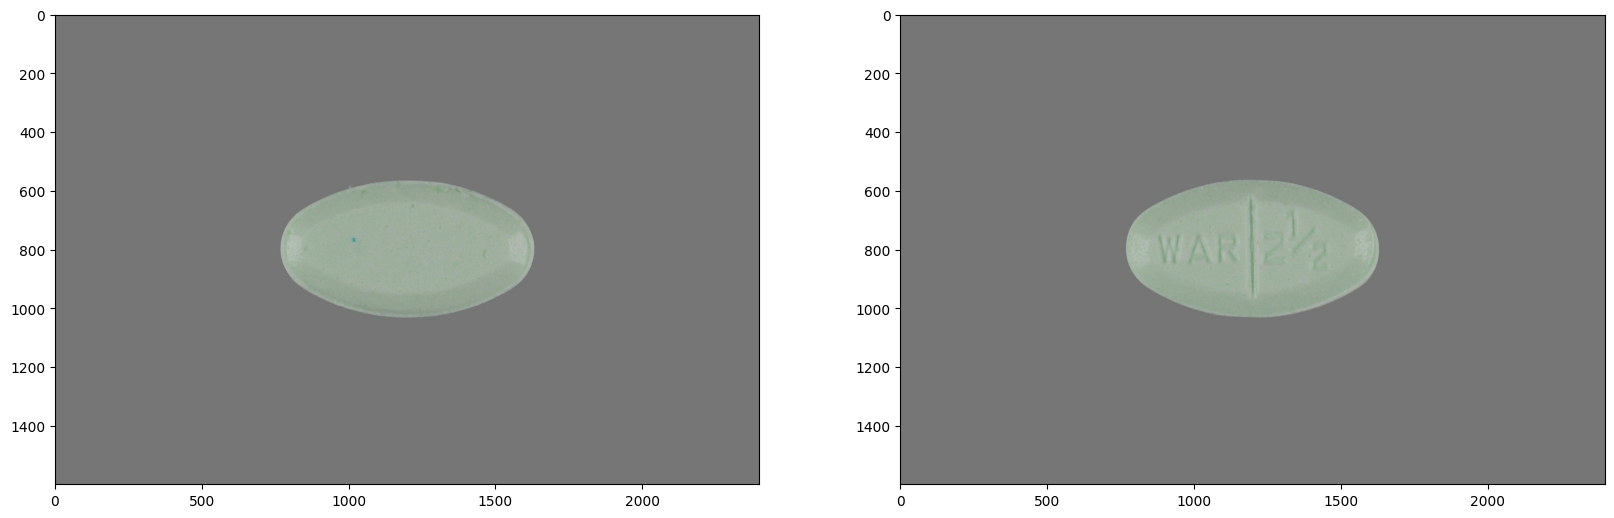

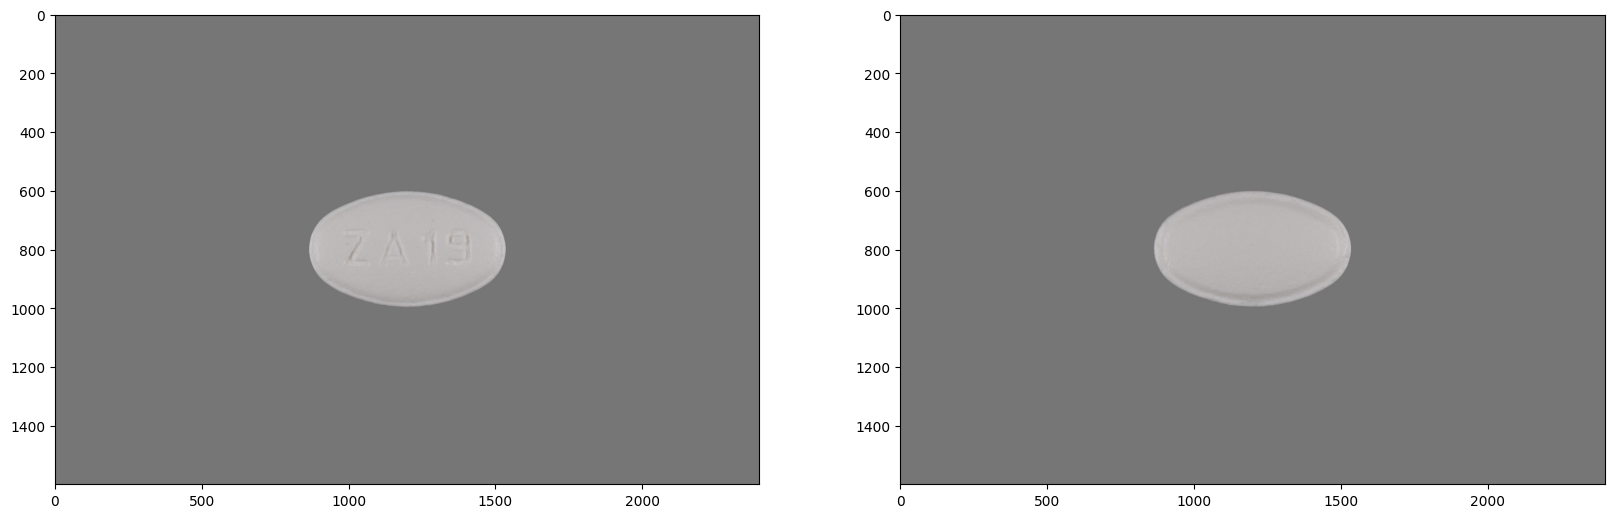

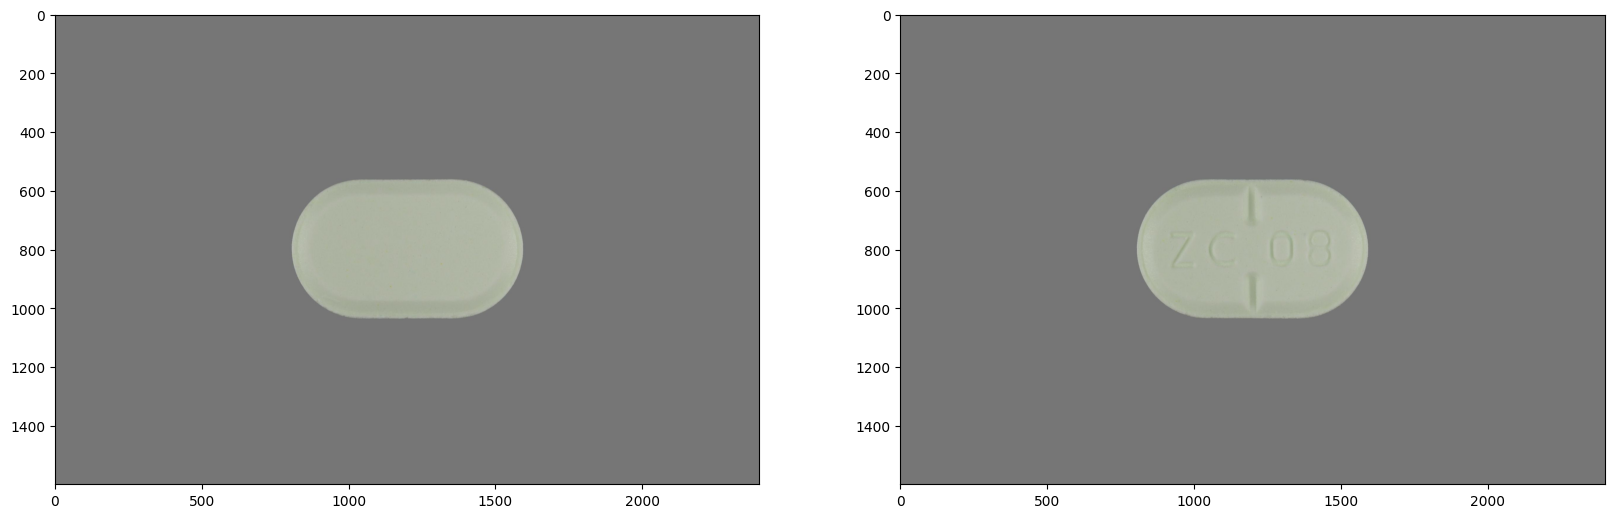

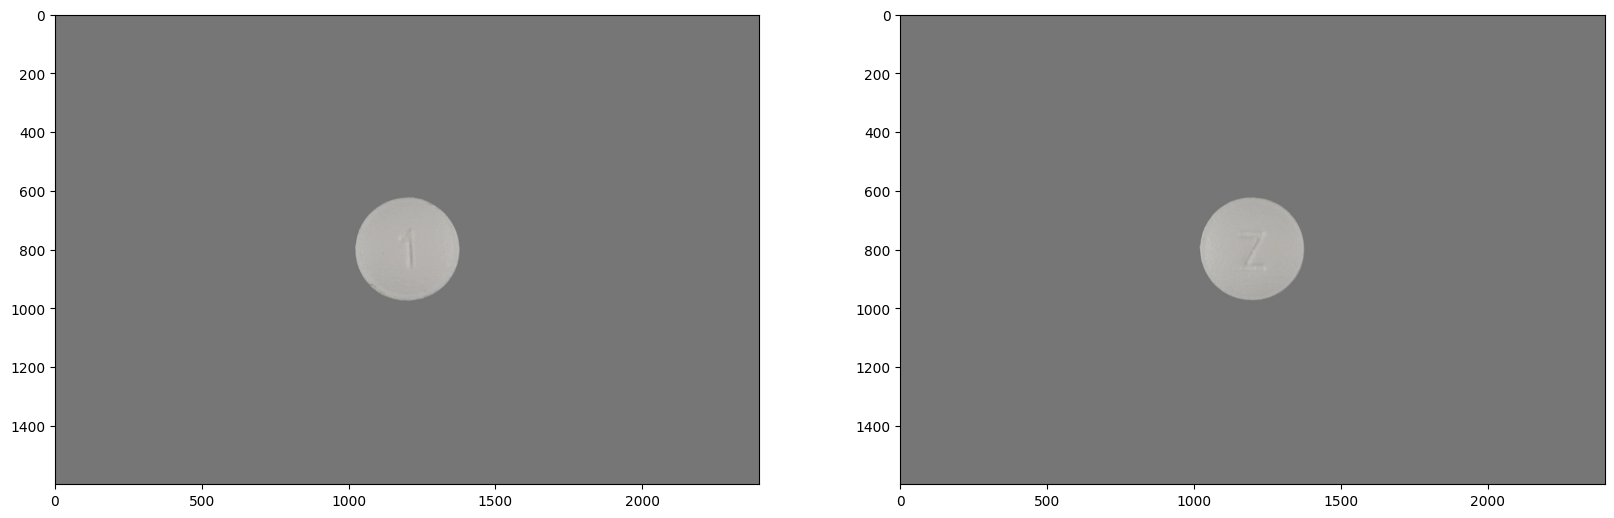

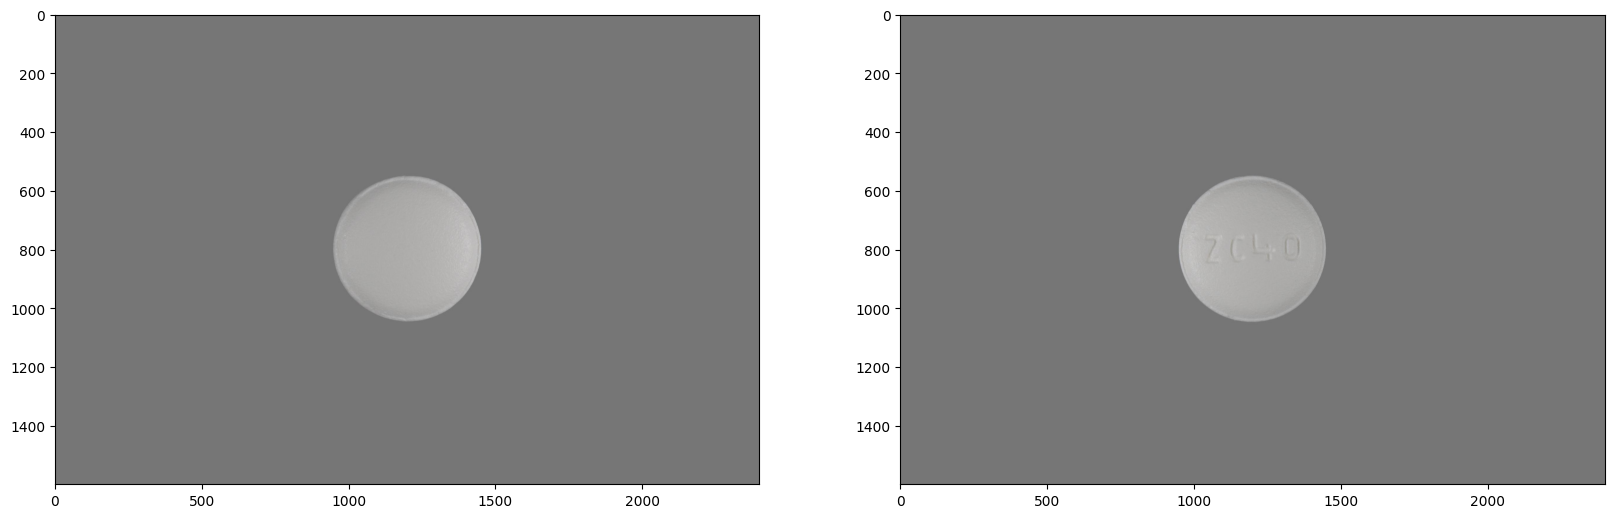

In [253]:
for idx, row_content in final_test_df.iterrows():
    if idx == 10:
        break
    img_list = [
        row_content["first_reference"],
        row_content["second_reference"],
        # row_content["consumer_1"],
        # row_content["consumer_2"],
        # row_content["consumer_3"],
        # row_content["consumer_4"],
        # row_content["consumer_5"],
    ]
    
    plot_images([os.path.join(DATA_DIR, "reference", img_path) for img_path in img_list])

## Extra

In [244]:
reference_df = master_df[master_df["layout"] == "MC_CHALLENGE_V1.0"]
reference_count_df = reference_df.groupby(["ndc11", "part"])["ndc11"].value_counts().reset_index()
reference_count_df = reference_count_df[(reference_count_df["count"]==2)&(reference_count_df["part"]==1)]
reference_list = reference_count_df["ndc11"].values[DATASET_SIZE:]
reference_df = reference_df[reference_df["part"] == 1]
reference_df = reference_df[reference_df["ndc11"].isin(reference_list)]
reference_df["reference_count"] = reference_df.groupby("ndc11")["image"].rank()
print("Number of rows in reference dataset:", len(reference_df))
print("Number of pills in reference dataset:", len(reference_df["ndc11"].unique()))

consumer_df = master_df[master_df["layout"] == "C3PI_Test"]
consumer_df = consumer_df[consumer_df["part"] == 1]
consumer_df = consumer_df[consumer_df["ndc11"].isin(reference_list)]

print("Number of rows in consumer dataset:", len(consumer_df))
print("Number of pills in consumer dataset:", len(consumer_df["ndc11"].unique()))

sampled_consumer_df = consumer_df.groupby("ndc11").agg({"image": partial(custom_sample, k=NO_CONSUMER_IMAGES)}).reset_index()
extra_test_df = pd.concat(
    [
        sampled_consumer_df[["ndc11"]],
        pd.DataFrame(sampled_consumer_df["image"].values.tolist(), columns=[f"consumer_{i+1}" for i in range(5)])
    ], axis=1
)
first_reference = reference_df[reference_df["reference_count"] == 1][["ndc11", "image"]].rename(columns={"image": "first_reference"})
second_reference = reference_df[reference_df["reference_count"] == 2][["ndc11", "image"]].rename(columns={"image": "second_reference"})

extra_test_df = extra_test_df.merge(first_reference, how="inner", on="ndc11")
extra_test_df = extra_test_df.merge(second_reference, how="inner", on="ndc11")

print(len(extra_test_df))

Number of rows in reference dataset: 134
Number of pills in reference dataset: 67
Number of rows in consumer dataset: 1077
Number of pills in consumer dataset: 67
67


In [245]:
pill_names = []
pill_metadatas = []

for _, row_content in final_test_df.iterrows():
    metadata1 = master_metadata[row_content["first_reference"]]
    metadata2 = master_metadata[row_content["second_reference"]]
    assert row_content["ndc11"] == metadata1["ndc11"] == metadata2["ndc11"], "NDCID mismatches for {}".format(row_content["ndc11"])
    assert metadata1["part"] == metadata2["part"], "Part mismatches for {}".format(row_content["ndc11"])
    assert metadata1["name"] == metadata2["name"], "Name mismatches for {}".format(row_content["ndc11"])
    assert metadata1["metadata"] == metadata2["metadata"], "Metadata mismatches for {}".format(row_content["ndc11"])
    pill_names.append(metadata1["name"])
    pill_metadatas.append(metadata1["metadata"])
    
extra_test_df["name"] = pill_names
extra_test_df["metadata"] = pill_metadatas

In [246]:
extra_test_df.to_csv(os.path.join(DATA_DIR, "extra_exp_metadata.csv"), index=False)